## error_correction package tutorial
Authors: Gloria Ha and Paul Dieterle

Description: With this package we can infer parameters for different models of error generation in spindle assembly.

Last updated: 4/14/2020

In [1]:
# import packages
from error_correction import data_io
from error_correction import generate_data
from error_correction.model import logLikeIndDelta
from error_correction.model import emcee_biased_fit
from error_correction.model import burnInPlotAffine
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Generative model derivation

For this tutorial we will focus on the most basic, "independent model."  We can denote $N$ as the number of chromosomes in each cell.  In this model, each chromosome has an equal low probability, $p$, of missegregation in a single division.  In this case, the probability of $M$ missegregations is given by

\begin{equation*}
    P(M) = {N\choose M}p^M(1-p)^{N-M}.
\end{equation*}

The experimental quantity being measured is the number of chromatids in each daughter cell after a single division. In particular, we are looking to calculate the distribution of *differences* in chromatid counts between the two daughter cells. We assume the $M$ chromosomes that missegregate fall into either daughter cell with equal probability. This gives $Q_1$ full chromosomes in daughter cell 1, meaning that daughter cell 1 has a number of chromatids $N_1$ given by

\begin{equation*}
     N_1 = N-M+2Q_1(M),
\end{equation*}

where $Q_1(M)$ is a random variable distributed according to

\begin{equation*}
     P(Q_1) = {M\choose Q_1}2^{-Q_1}2^{-(M-Q_1)} = {M\choose Q_1}2^{-M}.
\end{equation*}

From this, we can deduce that the distribution of $N_1$ is a simple convolution given by

\begin{equation*}
     P(N_1) = \sum_{M=0}^NP(M)P\left(Q_1 = \frac{N_1-N+M}{2}\right) = \sum_{M=0}^N{N\choose M}{M\choose \frac{N_1-N+M}{2}}2^{-M}p^M(1-p)^{N-M},
\end{equation*}

which tells us as well that the distribution of *differences* in chromatid counts,

\begin{equation*}
    P(\Delta = |N_1-N_2| = 2|N_1-N|),
\end{equation*}

is given by

\begin{equation*}
    P(\Delta) = P(N_1 = N-\Delta/2)+p(N_1=N+\Delta/2).
\end{equation*}

As such, we may construct a beautiful likelihood function given $n$ measurements with measurement $j$ showing chromatid difference $\Delta_j$:

\begin{equation*}
    L(p) = \prod_{n=1}^NP(\Delta_j).
\end{equation*}

Below, we give some demonstrations of this likelihood function with two synthetic datasets. In the future, we need to work to characterize our experimental noise. Of course, there is noise inherent to the biological process and measurement noise in counting chromatids.  We have decided on a functional form for the measurement noise -- we will have a probability of false negatives (dots that aren't counted in the image analysis), and each true chromatid has an independent chance of being counted or not counted (binomial).  We have yet to derive the likelihood for this additional layer.

Let us proceed with our demo.

### Generating synthetic data

With the code in our package, we can generate and store synthetic data for the independent and catastrophe models.  Here we will demonstrate how this data can be generated.  We will start by generating data from the independent model for high and low missegregation probability values.

In [2]:
# set up data directory and parameters
data_dir = 'example_data'
p_misseg = [0.003, 0.01]
n_cells = 100
n_chrom = 92
p_left = 0.5
p_fn = 0

# generate and store data
high_ind_data = generate_data.GenerateData('independent',
                                          [p_misseg[1], n_cells, n_chrom, p_left, p_fn],
                                          'high_ind',
                                          data_dir)
low_ind_data = generate_data.GenerateData('independent',
                                          [p_misseg[0], n_cells, n_chrom, p_left, p_fn],
                                          'low_ind',
                                          data_dir)

# display snippet of data
print(high_ind_data.data.head())

# display parameters
print(high_ind_data.params)

   errors  N_1  N_2  dNk  N_1_w_noise  N_2_w_noise  dNk_w_noise
0       1   91   93    2           91           93            2
1       1   91   93    2           91           93            2
2       0   92   92    0           92           92            0
3       0   92   92    0           92           92            0
4       0   92   92    0           92           92            0
{'p_misseg': 0.01, 'n_cells': 100, 'n_chrom': 92, 'p_left': 0.5, 'p_fn': 0}


The `GenerateData` class stores the data in a dataframe and the parameters in a dictionary, as seen above.  The synthetic data includes some information that is hidden in the real data, such as the true number of errors, and the true number of chromatids per cell.

This has also generated two data files per set of parameters, `data_high_ind.txt` and `params_low_ind.yml` in the `example_data` directory, which can then be parsed using the `SyntheticData` class in the `data_io` module.

In [3]:
# let's import the data that we generated
imported_high_ind = data_io.SyntheticData('params_high_ind.yml',
                                          'data_high_ind.txt',
                                          data_dir)
imported_low_ind = data_io.SyntheticData('params_low_ind.yml',
                                         'data_low_ind.txt',
                                         data_dir)
# display snippet of data
print(imported_high_ind.data.head())

# display parameters
print(imported_high_ind.params)

   errors  N_1  N_2  dNk  N_1_w_noise  N_2_w_noise  dNk_w_noise
0       1   91   93    2           91           93            2
1       1   91   93    2           91           93            2
2       0   92   92    0           92           92            0
3       0   92   92    0           92           92            0
4       0   92   92    0           92           92            0
{'n_cells': 100, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.01}


We can see that the information is recovered when we parse the data files. 

### Parameter estimation

Now we can use our log likelihood function derived above to calculate do parameter estimation on the most likely value of the error rate.

In [4]:
# Next, we determine what range of p we would like to examine
p_range = np.linspace(0.001,0.02,100)

# Then, we calculate our likelihoods
like_high = [logLikeIndDelta(imported_high_ind,[i]) for i in p_range]
like_low = [logLikeIndDelta(imported_low_ind,[i]) for i in p_range]

Let's plot the results.

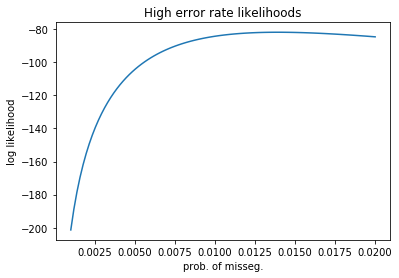

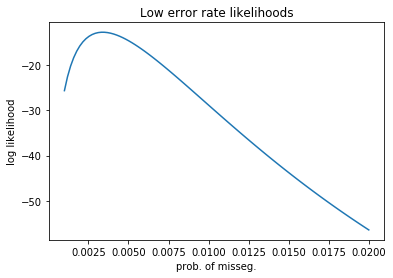

In [5]:
# Then we plot
xl = 'prob. of misseg.'
yl = 'log likelihood'

plt.figure();
plt.plot(p_range,like_high);
plt.xlabel(xl);
plt.ylabel(yl);
plt.title('High error rate likelihoods');

plt.figure();
plt.plot(p_range,like_low);
plt.xlabel(xl);
plt.ylabel(yl);
plt.title('Low error rate likelihoods');


We can report the maximum likelihood estimate for the probability of missegregation.

In [6]:
print('MLE p_misseg for high error rate independent model data: ', p_range[np.argmax(like_high)])
print('MLE p_misseg for low error rate independent model data: ', p_range[np.argmax(like_low)])

MLE p_misseg for high error rate independent model data:  0.013858585858585858
MLE p_misseg for low error rate independent model data:  0.003303030303030303


As we can see, these inferred likelihoods indeed agree quite well with the actual values

In [7]:
print(imported_low_ind.params)
print(imported_high_ind.params)

{'n_cells': 100, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.003}
{'n_cells': 100, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.01}


Of course, one can imagine more complex models. One that we are interested in is the biased, independent missegregation model. In such a scenario, chromosomes that missegregate prefer cell 1 to cell 2, with the probability of ending up in cell 2 being $\alpha<0.5$. In this case, we must adjust the above analysis, which entails a modification of $P(N_1)$ according to:

\begin{equation*}
     P(N_1) = \sum_{M=0}^NP(M)P\left(Q_1 = \frac{N_1-N+M}{2}\right) = \sum_{M=0}^N{N\choose M}{M\choose \frac{N_1-N+M}{2}}\alpha^{(N_1-N+M)/2}(1-\alpha)^{(M-N_1+N)/2}p^M(1-p)^{N-M},
\end{equation*}

Let's see how our inference fares when we increase the complexity of the model.  One parameter that we have not focused on is `p_left`, or the probability that a missegregation ends up in the left cell (directionality is arbitrary here), or that missegregation is directionally biased for some reason.  The underlying biology that could lead to such biased missegregation could be an asymmetric spindle.  We can look at two datasets -- one with perfectly symmetric missegregation (`p_left=0.5`, this dataset was created above) and one with highly asymmetric missegregation (`p_left=0.9`, which we will create now).  We can leave the probability of missegregation fixed at the higher bound 0.01 and use `emcee` to infer the parameters.

In [8]:
# generate and store data
biased_high_ind_data = generate_data.GenerateData('independent',
                                          [p_misseg[1], n_cells, n_chrom, 0.1, p_fn],
                                          'biased_high_ind',
                                          data_dir)

Let's run the inference!

In [9]:
sampler_unbiased = emcee_biased_fit(imported_high_ind, nwalkers=10, nsteps=1000)
sampler_biased = emcee_biased_fit(biased_high_ind_data, nwalkers=10, nsteps=1000)

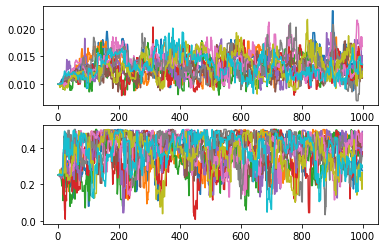

In [10]:
burnInPlotAffine(2, sampler_unbiased)

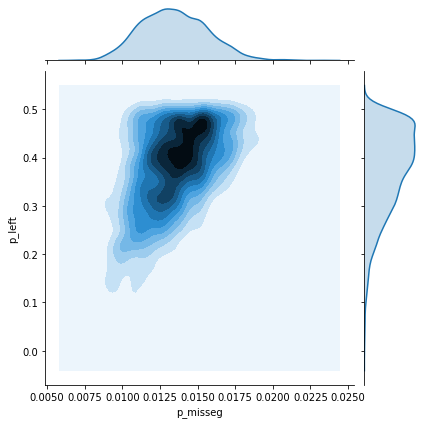

In [11]:
burnPt = 400
nDim = 2

samples = sampler_unbiased.chain[:,burnPt:,:]
traces = samples.reshape(-1, nDim).T
paramSampsUnbiased = pd.DataFrame({'p_misseg': traces[0], 'p_left': traces[1]})

scatterPlot = sns.jointplot(x='p_misseg', y='p_left', data=paramSampsUnbiased, 
                            kind='kde');

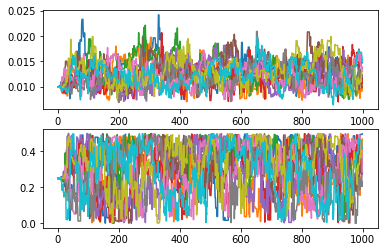

In [12]:
burnInPlotAffine(2, sampler_biased)

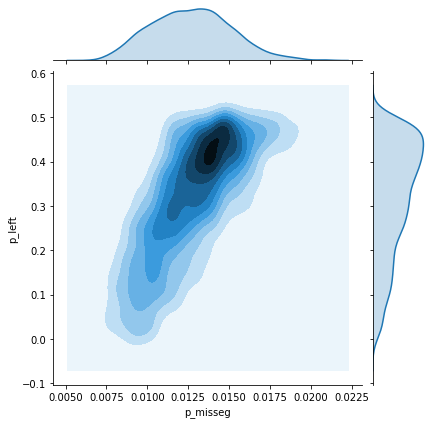

In [13]:
burnPt = 400
nDim = 2

samples = sampler_biased.chain[:,burnPt:,:]
traces = samples.reshape(-1, nDim).T
paramSampsBiased = pd.DataFrame({'p_misseg': traces[0], 'p_left': traces[1]})

scatterPlot = sns.jointplot(x='p_misseg', y='p_left', data=paramSampsBiased, 
                            kind='kde');

The MCMC seems to correctly infer the probability of missegregation, but seems a lot more shaky on the biased missegregation probability.  This implies we may have a flat likelihood function along some directions in parameter space; perhaps this is a very difficult parameter estimation problem.

We can take a look at the marginalized MAP values.

In [14]:
print(paramSampsUnbiased.quantile([0.50], axis=0))
print(paramSampsBiased.quantile([0.50], axis=0))

     p_misseg    p_left
0.5  0.013347  0.389674
     p_misseg    p_left
0.5  0.012686  0.341629
